## Linear regression model for car price forecasting

Importing all necessary modules

In [396]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools as it


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
import xgboost as xgb


from sklearn.model_selection import train_test_split, cross_validate, learning_curve, cross_val_score, ShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce

import eli5
from eli5.sklearn import PermutationImportance

import seaborn as sns
sns.set()

# Data cleanzing and transforming functions

In [397]:
def outliers_remove(dataset,train):

    """ Remove outliers based on interquantile range.
    
        Keyword arguments:
        dataset -- dataset, used for outliers removal
        train -- dataset, used to calculate threshold
    """
        
    iqr=train['Price'].quantile(0.75)-train['Price'].quantile(0.25)
    dataset=dataset[dataset['Price']<=train['Price'].quantile(0.75)+iqr*1.5]
    dataset=dataset[dataset['Price']>=train['Price'].quantile(0.25)-iqr*1.5]
        
    return dataset


In [398]:
def leverage_remove(dataset, dataset_train): 

    """ Remove observations with high leverage.

        Keyword arguments:
        dataset -- dataset, used for leverage removal
        dataset_train -- dataset, used in imputing and transformation fit
    """
    
    y_to_transform=dataset.Price
    X_train=dataset_train.drop('Price',axis=1)
    X_to_transform=dataset.drop('Price',axis=1)
    
    X_to_transform=numerical_preprocessor(X_to_transform, X_train)

    X_lev=X_to_transform.select_dtypes(['float64','int64'])
    model_lev = sm.OLS(y_to_transform, sm.add_constant(X_lev)).fit()

    influence = model_lev.get_influence()
    leverage = influence.hat_matrix_diag
    inf_sum = influence.summary_frame()

    price_res = pd.concat([y_to_transform, inf_sum], axis = 1)
    price_res=price_res.rename(columns={'hat_diag': 'leverage'})

    l = price_res.leverage
    leverage_observations = price_res.Price[abs(l) > ((X_to_transform.shape[1])+1)/X_to_transform.shape[0]]
    print ('High leverage:',leverage_observations.count())
    
    data=dataset[dataset.index.isin(leverage_observations.index)==False]


    return data

In [399]:
def columns_numerical(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [400]:
def columns_categorical(X_train):
    return [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and 
                            X_train[cname].dtype == "object"and cname.find('target')<0 and cname.find("_") < 0]

In [401]:
def columns_target(X_train):
    return [cname for cname in X_train.columns if X_train[cname].dtype == "object" and X_train[cname].nunique() >= 10 or
            cname.find("_") > 0]

In [402]:
def numerical_preprocessor(X_to_transform, X_train):
    """ Transform numerical columns. Used out of pipeline on train and test data samples.
        
        Keyword arguments:
        X_to_transform -- dataset to transform
        X_train -- dataset to fit
    """
    # Select numerical columns
    numerical_cols = columns_numerical(X_train)

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    X_transformed=X_to_transform.copy()
    numerical_transformer.fit(X_train[numerical_cols])
    
    X_transformed[numerical_cols]=numerical_transformer.transform(X_to_transform[numerical_cols])
    
    return X_transformed

In [403]:
def big_categorical_preprocessor (X_train, y_train):
    
    """ Transform numerical columns. Used out of pipeline on train data sample only.

        Keyword arguments:
        X_train -- dataset to transform
        y_train -- target to fit
    """
    # Select categorical columns with relatively high cardinality 

    big_categorical_cols_target = columns_target(X_train)
    
    
    # Preprocessing
    big_categorical_transformer_target=ce.TargetEncoder(cols=big_categorical_cols_target)
    
    
    X_transformed=X_train.copy()
    X_transformed[big_categorical_cols_target]=big_categorical_transformer_target.fit_transform(X_train[big_categorical_cols_target], y_train)
    return X_transformed

In [404]:
def pipeline_preprocessing (X):
    
    """ Set preprocessing based on the type of the column """
    
    # Select categorical columns with relatively low and high cardinality 
    
    categorical_cols = columns_categorical(X)

    big_categorical_cols_target = columns_target(X)
    
    # Select numerical columns
    numerical_cols = columns_numerical(X)

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])



    # Preprocessing for categorical data
    categorical_transformer = OneHotEncoder(sparse=False, drop='first')

    big_categorical_transformer_target=ce.TargetEncoder()


    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('big_cat_target',big_categorical_transformer_target, big_categorical_cols_target)])
    
    return preprocessor

# Features functions

In [405]:
def multicolinearity_check(X):
    
    """ Calculate variance inflation factor for numerical columns """
    
    X=numerical_preprocessor(X,X)
    variables=X.select_dtypes(['float64','int64'])
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif["features"] = variables.columns
    return vif

In [406]:
def create_interactions(dataset):
    
    """ Create new columns with interactions  """
    
    cat_features = dataset.select_dtypes('object').columns
    name=""
    
    for item in it.combinations(cat_features, 2):
        name=item[0]+"_"+item[1]
        dataset[name]=dataset[item[0]].astype('str')+"_"+dataset[item[1]].astype('str')
    
    
    return dataset

In [407]:
def features_importance(X_train, y_train):
    
    """ Check features importance.

        Keyword arguments:
        X_train -- features
        y_train -- target
    """
    model=LinearRegression()
    X_tocheck=X_train.select_dtypes(['float64','int64'])

    model.fit(X_tocheck, y_train)
    perm = PermutationImportance(model, random_state=0).fit(X_tocheck, y_train)
    return eli5.show_weights(perm, feature_names = X_tocheck.columns.tolist())
    

# Modeling fucntions

Fit OLS model from statsmodel to check regression summary table.

In [408]:
def OLS_with_summary(X_train, y_train):
    
    """ OLS model from statsmodel library.

        Keyword arguments:
        X_train -- features
        y_train -- target
    """
    
    X_train_OLS = pd.get_dummies(X_train, drop_first=True)
    
    
    X = sm.add_constant(X_train_OLS)
    model_OLS = sm.OLS(y_train,X)
    results = model_OLS.fit()
    
    #return linear regression summary
    return results.summary()

Fit sklearn pipeline with linear regression

In [409]:
def pipeline_fit(X_train,y_train):
    
    """ Fit pipeline.

        Keyword arguments:
        X_train -- features
        y_train -- target
    """
                            
    preprocessor=pipeline_preprocessing(X_train)
    model=LinearRegression()
#     reg2=GradientBoostingRegressor()
#     reg3=xgb.XGBRegressor()
#     model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
#     model=xgb.XGBRegressor(verbosity=0)
    
#     poly = PolynomialFeatures(degree=2,interaction_only=True)
    
    # Bundle preprocessing and modeling code in a pipeline
#     my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('poly', poly), ('model', model)])
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])


    # Preprocessing of training data, fit model 
#     my_pipeline=my_pipeline.fit(X_train, y_train, model__sample_weight = [1/(y+5) for y in y_train])
    my_pipeline=my_pipeline.fit(X_train, y_train)
#     print('R2: {}, Intercept: {}'.format(my_pipeline.score(X_train, y_train).round(decimals=3), my_pipeline.named_steps['model'].intercept_.round(decimals=3)))
    return my_pipeline

In [410]:
def predictions(X_train, y_train, X_test, y_test):
    
    """ Calculate predictions and errors.

        Keyword arguments:
        X_train -- train data sample with features
        y_train -- train data sample with target
        X_test -- test data sample with features
        y_test -- test data sample with target
    """
    
    pipeline=pipeline_fit(X_train,y_train)

    # Preprocessing of validation data, get predictions
    preds = pipeline.predict(X_test)

    #Create data frame with predictions and residuals
    predictions=pd.DataFrame(np.exp(preds), columns=['Prediction'])
    y_test = y_test.reset_index(drop=False)
   
    
    predictions['Car_index']=y_test['index']
    predictions['Target']=np.exp(y_test['Price'])
    predictions['Residuals']=predictions['Target']-predictions['Prediction']
    predictions['Difference%'] = np.absolute(predictions['Residuals']/predictions['Target']*100)
    
    # Evaluate the model
    score_mae = mean_absolute_error(predictions['Target'], predictions['Prediction'])
    score_rmse=math.sqrt(mean_squared_error(predictions['Target'], predictions['Prediction']))
    MAPE=np.abs(predictions['Residuals']).sum()/predictions['Target'].sum()*100
    
    print('MAE:', score_mae.round(decimals=2))
    print('RMSE:', score_rmse)
    print('MAPE: {}%'.format(MAPE.round(decimals=2)))
    
    return predictions


In [411]:
def validation(X_train, y_train, X_val, y_val):
    
    """ Calculate RMSE.

        Keyword arguments:
        X_train -- train data sample with features
        y_train -- train data sample with target
        X_val -- validation data sample with features
        y_val -- validation data sample with target
    """
    
    pipeline=pipeline_fit(X_train,y_train)

    # Preprocessing of validation data, get predictions
    preds = pipeline.predict(X_val)    
    
    return math.sqrt(mean_squared_error(np.exp(y_val), np.exp(preds)))

In [412]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


Import dataset

In [413]:
data = pd.read_csv('1.04. Real-life example.csv')
data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


There are 4 numeric and 5 categorical variables. Target column - Price - contains missing values, so we need to remove them.
Also there are missed values in "EngineV" column - it'll be handled with help of SimpleImputer (mean strategy). 

In [414]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
Brand           4345 non-null object
Price           4173 non-null float64
Body            4345 non-null object
Mileage         4345 non-null int64
EngineV         4195 non-null float64
Engine Type     4345 non-null object
Registration    4345 non-null object
Year            4345 non-null int64
Model           4345 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


In [415]:
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [416]:
data.dropna(subset=['Price'],axis=0,inplace=True)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4173,4173.000000,4173,4173.000000,4025.000000,4173,4173,4173.000000,4173
unique,7,NaN,6,NaN,NaN,4,2,NaN,310
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,908,NaN,1604,NaN,NaN,1903,3779,NaN,193
mean,NaN,19418.746935,NaN,164.088426,2.764586,NaN,NaN,2006.367362,NaN
std,NaN,25584.242620,NaN,104.823056,4.935941,NaN,NaN,6.686728,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [493]:
# duplicate=data.duplicated(subset=["Brand",'Body','EngineV','Engine Type','Registration','Year','Model'])
# data_dubl=data.loc[duplicate[duplicate==True].index,:]

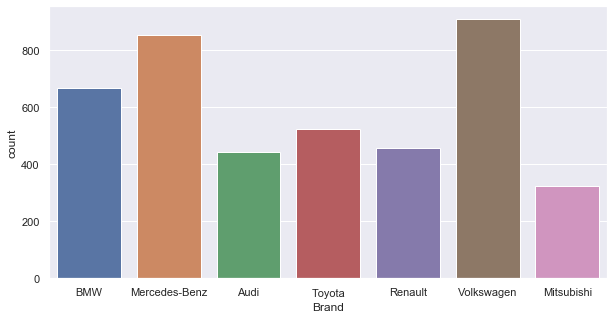

In [417]:
plt.figure(figsize=(10,5))
sns.countplot(data.Brand)

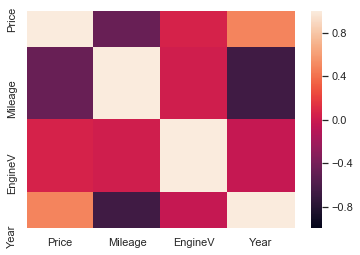

In [418]:
sns.heatmap(data.corr(), fmt = ".2f",vmin=-1.0, vmax=1.0);

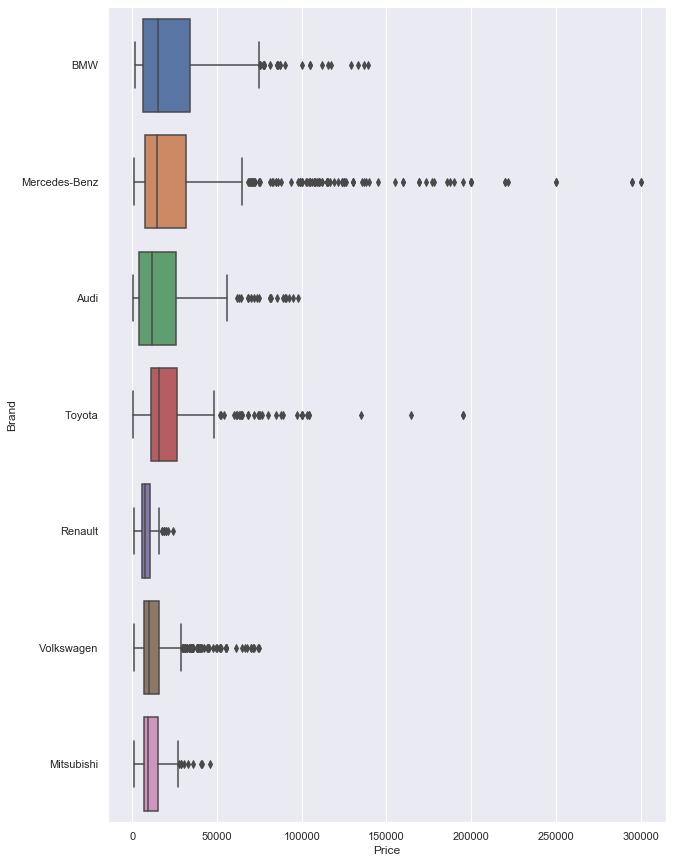

In [480]:
plt.figure(figsize=(10,15))
sns.boxplot(y=data.Brand, x=data.Price, orient='h',whis=1.5);

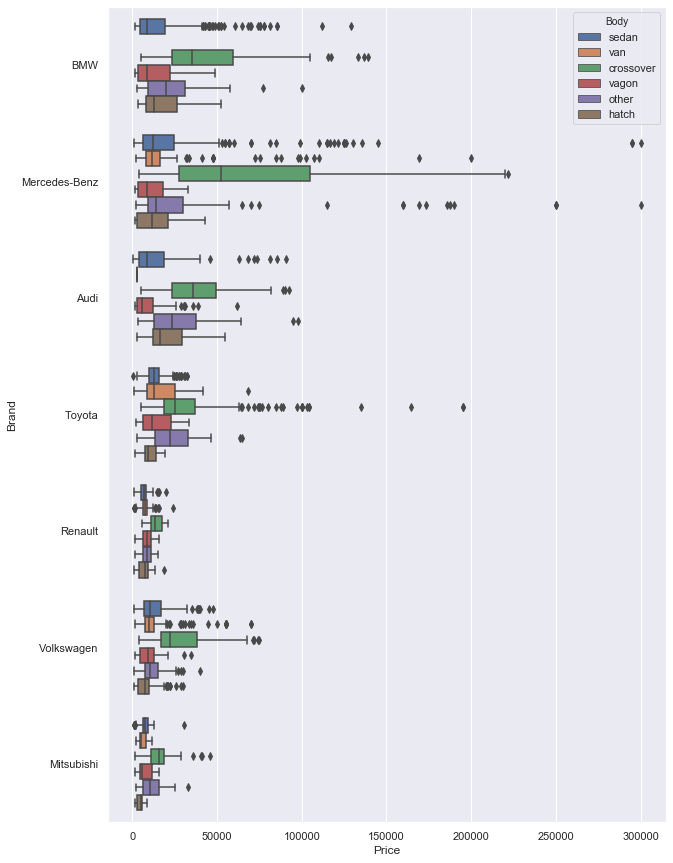

In [419]:
plt.figure(figsize=(10,15))
sns.boxplot(y=data.Brand, x=data.Price, hue=data.Body, orient='h',whis=1.5);

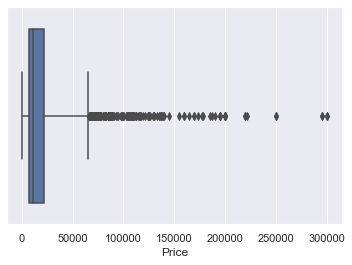

In [420]:
sns.boxplot(data.Price, whis=3);

<Figure size 504x504 with 0 Axes>

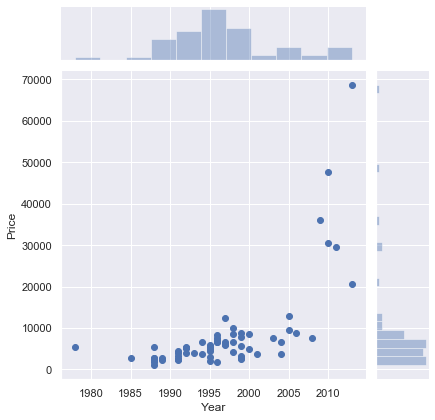

In [421]:
plt.figure(figsize=(7,7))
sns.jointplot(y=data[data.Mileage>400].Price, x=data[data.Mileage>400].Year);

In [422]:
index_none=data[(data['Mileage']==0) & (data["Year"]<2010)].index
data.loc[index_none,"Mileage"]=None
data[(data['Mileage']==0) & (data["Year"]<2010)]

index_none=data[(data['Mileage']>400) & (data["Year"]>2008)].index
data.loc[index_none,"Mileage"]=None
data[(data['Mileage']>400) & (data["Year"]>2008)]

# data=data[data.Year>1970]
# data=data[data.Mileage<650]

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model


In [423]:
data_extrem=data[data.Price>data.Price.quantile(0.75)+(data.Price.quantile(0.75)-data.Price.quantile(0.25))*3]
data_extrem.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,195,195.000000,195,194.000000,192.000000,195,195,195.000000,195
unique,5,NaN,4,NaN,NaN,3,1,NaN,46
top,Mercedes-Benz,NaN,crossover,NaN,NaN,Diesel,yes,NaN,Land Cruiser 200
freq,102,NaN,122,NaN,NaN,115,195,NaN,22
mean,NaN,109563.613077,NaN,15.654639,3.737292,NaN,NaN,2014.830769,NaN
std,NaN,48387.015152,NaN,23.427527,1.177177,NaN,NaN,1.685926,NaN
min,NaN,66200.000000,NaN,0.000000,1.600000,NaN,NaN,2007.000000,NaN
25%,NaN,74949.500000,NaN,0.000000,3.000000,NaN,NaN,2014.000000,NaN
50%,NaN,99000.000000,NaN,1.000000,3.000000,NaN,NaN,2016.000000,NaN
75%,NaN,124000.000000,NaN,24.500000,4.500000,NaN,NaN,2016.000000,NaN


In [424]:
# data_extrem.Price=np.log(data_extrem.Price)
# sns.pairplot(data_extrem.select_dtypes(['float64','int64']), height=2.5)
# plt.tight_layout();

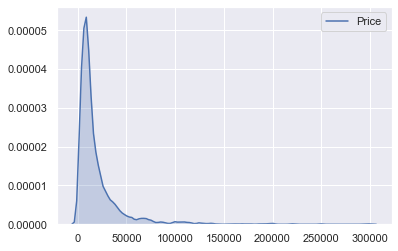

In [425]:
sns.kdeplot(data.Price, shade=True);

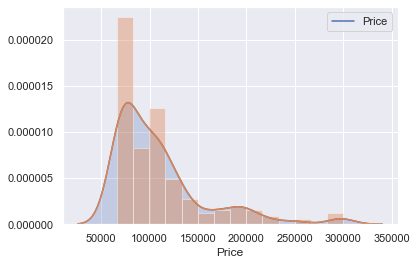

In [426]:
sns.kdeplot(data_extrem.Price, shade=True);
sns.distplot(data_extrem.Price, kde=True);

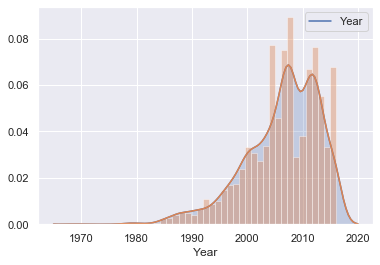

In [427]:
sns.kdeplot(data.Year, shade=True);
sns.distplot(data.Year, kde=True);

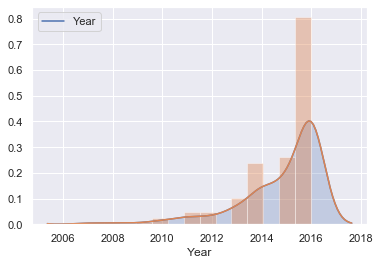

In [428]:
sns.kdeplot(data_extrem.Year, shade=True);
sns.distplot(data_extrem.Year, kde=True);

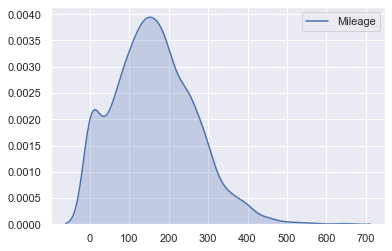

In [429]:
sns.kdeplot(data.Mileage, shade=True);

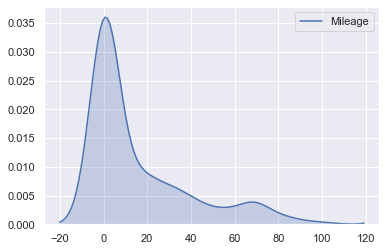

In [430]:
sns.kdeplot(data_extrem.Mileage, shade=True);

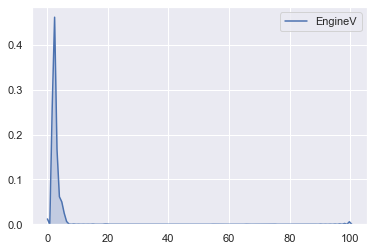

In [431]:
sns.kdeplot(data.EngineV, shade=True);

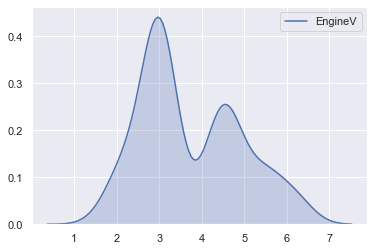

In [432]:
sns.kdeplot(data_extrem.EngineV, shade=True);

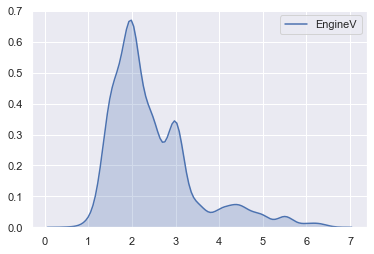

In [433]:
sns.kdeplot(data.EngineV[data.EngineV<data.EngineV.quantile(0.75)+(data.EngineV.quantile(0.75)-data.EngineV.quantile(0.25))*3], shade=True);

In [434]:
# Replace incorrect values of engine volume on NaN (higher than 7 litres)
data['EngineV']=data['EngineV'].apply(lambda x: [None if x > 7 else x][0])

#Convert 'Registration' to boolean
data['Registration']=data['Registration'].replace({'yes':True,'no':False})

data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4173,4173.000000,4173,4164.000000,4003.000000,4173,4173,4173.000000,4173
unique,7,NaN,6,NaN,NaN,4,2,NaN,310
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,True,NaN,E-Class
freq,908,NaN,1604,NaN,NaN,1903,3779,NaN,193
mean,NaN,19418.746935,NaN,163.239914,2.467732,NaN,NaN,2006.367362,NaN
std,NaN,25584.242620,NaN,101.609376,0.975549,NaN,NaN,6.686728,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Below we can see that price has exponential relationship with Year and Mileage. So log transformation for target variable can be applied. There are visible several outliers which should be removed.

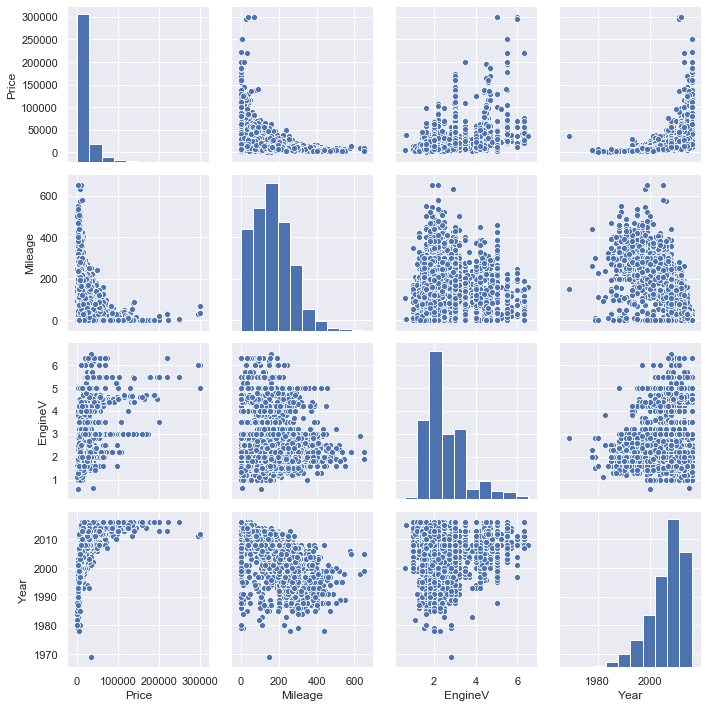

In [435]:
sns.pairplot(data.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout();

Create X and y variables, test and train samples.

In [436]:
y=data.Price
X=data.drop(['Price'], axis=1)

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

In [438]:
data_train=data[data.index.isin(X_train.index)]
data_test=data[data.index.isin(X_test.index)]
# data_val=data[data.index.isin(X_val.index)]

In [439]:
data_train.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3338,3338.000000,3338,3331.000000,3204.000000,3338,3338,3338.000000,3338
unique,7,NaN,6,NaN,NaN,4,2,NaN,296
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,True,NaN,E-Class
freq,731,NaN,1285,NaN,NaN,1511,3019,NaN,146
mean,NaN,19346.016141,NaN,162.816872,2.460534,NaN,NaN,2006.369682,NaN
std,NaN,25490.905598,NaN,101.160620,0.974197,NaN,NaN,6.736351,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6950.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11450.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21937.500000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [440]:
# data_val.describe(include='all')

In [441]:
data_test.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,835,835.000000,835,833.000000,799.000000,835,835,835.000000,835
unique,7,NaN,6,NaN,NaN,4,2,NaN,168
top,Mercedes-Benz,NaN,sedan,NaN,NaN,Diesel,True,NaN,E-Class
freq,186,NaN,319,NaN,NaN,392,760,NaN,47
mean,NaN,19709.495904,NaN,164.931573,2.496596,NaN,NaN,2006.358084,NaN
std,NaN,25967.422353,NaN,103.428668,0.981036,NaN,NaN,6.488501,NaN
min,NaN,1200.000000,NaN,0.000000,1.000000,NaN,NaN,1978.000000,NaN
25%,NaN,6999.500000,NaN,95.000000,1.900000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21000.000000,NaN,235.000000,3.000000,NaN,NaN,2011.000000,NaN


In [442]:
# remove outliers and observations with high leverage in the train dataset
# data_clean=outliers_remove(data_train,data_train)
# data_clean=leverage_remove(data_clean, data_clean)

# print(data_clean.describe())

# log transformation for target variable in the train dataset

# data_clean['Price']= np.log(data_clean['Price'])

# y_train=data_clean.Price
# X_train=data_clean.drop(['Price'], axis=1)

data_train['Price']= np.log(data_train['Price'])
y_train=data_train.Price
X_train=data_train.drop(['Price'], axis=1)

In [443]:
# remove outliers and observations with high leverage in the test dataset
# data_clean_test=outliers_remove(data_test, data_train)
# data_clean_test=leverage_remove(data_clean_test, data_clean)

# print(data_clean_test.describe())

# log transformation for target variable in the test dataset
# data_clean_test['Price']= np.log(data_clean_test['Price'])

data_test['Price']= np.log(data_test['Price'])

y_test=data_test.Price
X_test=data_test.drop(['Price'], axis=1)


data_val['Price']= np.log(data_val['Price'])

y_val=data_val.Price
X_val=data_val.drop(['Price'], axis=1)

After outliers/leverage removal and log-transformation of target variable, the relationship between features and target looks more linear and applicable for linear regression model. However, there are still some observations that looks like outliers.

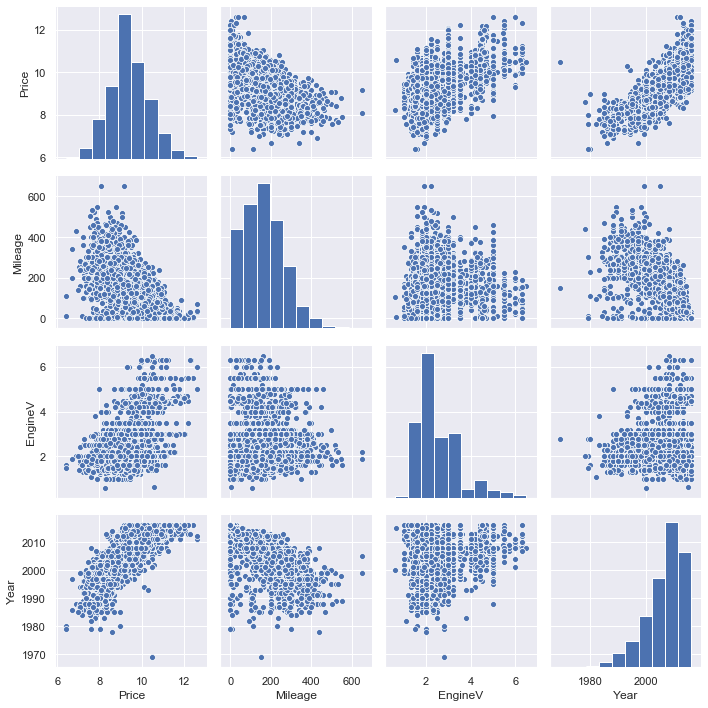

In [444]:
sns.pairplot(data_train.select_dtypes(['float64','int64']), height=2.5)
plt.tight_layout();

Firstly numerical transformer was applied, then calculate VIF to check multicolinearity. All coefficients are less then 5, so can use all of them further.

,VIF,features
0,1.851918,Mileage
1,1.001442,EngineV
2,1.852207,Year


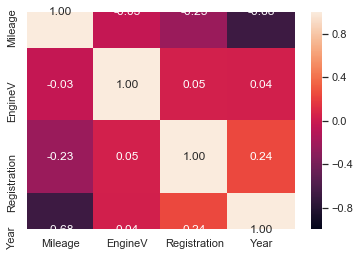

In [445]:
sns.heatmap(X_train.corr(), fmt = ".2f", vmin=-1, vmax=1, annot=True)
VIF=multicolinearity_check(X_train)
VIF

Create variables with iteractions to check influence of potential new variables in the model.

In [446]:
data_interactions=create_interactions(data_train)

X_train=data_interactions.drop(['Price'], axis=1)


Transform variables: numerical (SimpleImputer, Scaler) and categorical (TargetEncoder).

In [447]:
X_train_transformed=numerical_preprocessor(X_train,X_train)
X_train_transformed=big_categorical_preprocessor(X_train_transformed,y_train)

Check features importance with help of PermutationImportance. We can see that 'Model', 'Year' and 'Brand_Model' have the highest weights. There may be strong multicollinearity between 'Model' and 'Brand_Model', so before include features in model let's once more check VIF.

In [448]:
features_importance(X_train_transformed, y_train)

Weight,Feature
0.7430 ± 0.0142,Model
0.5972 ± 0.0174,Brand_Model
0.4729 ± 0.0224,Year
0.1265 ± 0.0064,Engine Type_Model
0.0733 ± 0.0033,EngineV
0.0379 ± 0.0036,Brand_Body
0.0271 ± 0.0021,Mileage
0.0252 ± 0.0025,Body_Model
0.0090 ± 0.0011,Brand_Engine Type
0.0050 ± 0.0008,Body_Engine Type


We can see below that assumption about multicollinearity was correct. Let's remove all interactions and check once more ('Model' factor has higher weight than 'Brand_Model', so better remove interactions).

In [449]:
VIF_with_interactions=multicolinearity_check(X_train_transformed)
VIF_with_interactions

,VIF,features
0,1.948596,Mileage
1,1.796570,EngineV
2,2.274576,Year
3,3485.723664,Model
4,4.746484,Brand_Body
5,1.612623,Brand_Engine Type
6,3468.176818,Brand_Model
7,3.492709,Body_Engine Type
8,10.131082,Body_Model
9,7.998517,Engine Type_Model


In [450]:
X_train_final=X_train_transformed[columns_numerical(X_train)+['Model']]
VIF_final=multicolinearity_check(X_train_final)
VIF_final

,VIF,features
0,1.893773,Mileage
1,1.679530,EngineV
2,2.213436,Year
3,2.294673,Model


In [451]:
features_importance(X_train_final, y_train)

Weight,Feature
0.4614 ± 0.0175,Year
0.2289 ± 0.0079,Model
0.1045 ± 0.0057,EngineV
0.0337 ± 0.0051,Mileage


There are no multicollinearity between selected factors, so we can use all of them in the regression model.

In [452]:
# add back categorical variables with low cardinality and boolean 'Registration'
X_train_final=X_train_final.join(X_train[columns_categorical])
X_train_final=X_train_final.join(X_train['Registration'])
# X_train_final.drop(columns=["Mileage"], inplace=True)
X_train_final.head()

,Mileage,EngineV,Year,Model,Brand,Body,Engine Type,Registration
0,1.130086,-0.482591,-2.281945,8.912560,BMW,sedan,Petrol,True
2,1.931754,2.661096,-0.500299,10.289198,Mercedes-Benz,sedan,Gas,True
3,0.763892,1.822779,0.093584,10.463865,Audi,crossover,Petrol,True
5,-1.611421,3.185043,1.429819,12.037961,Mercedes-Benz,crossover,Petrol,True
6,2.723525,-0.482591,-1.391122,8.912560,BMW,sedan,Gas,True


In [453]:
X_train_final=X_train.loc[:,X_train_final.columns]
X_train_final.loc[:,'Registration']=X_train_final.loc[:,'Registration'].astype('str')

X_test_final=X_test.loc[:,X_train_final.columns]
X_test_final.loc[:,'Registration']=X_test_final.loc[:,'Registration'].astype('str')

X_val_final=X_val.loc[:,X_train_final.columns]
X_val_final.loc[:,'Registration']=X_val_final.loc[:,'Registration'].astype('str')

In [454]:
# sns.pairplot(data_train.select_dtypes(['float64','int64']), height=2.5)
# plt.tight_layout();

Create regression model with summary. R-squared is high enough, p-values of the model and features are lower 0.05.

In [455]:
# X_train_transformed_final=numerical_preprocessor(X_train_final,X_train_final)
# X_train_transformed_final=big_categorical_preprocessor(X_train_transformed_final,y_train)


# OLS_with_summary(X_train_transformed_final, y_train)

Create the same model with help of sklearn and calculate errors (MAE, MAPE). 

In [456]:
X_curves=pipeline_fit(X_train_final,y_train)[0].fit_transform(X_train,y_train)
X_curves.shape
y_train.shape

(3338,)

<module 'matplotlib.pyplot' from 'C:\\Users\\kater\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

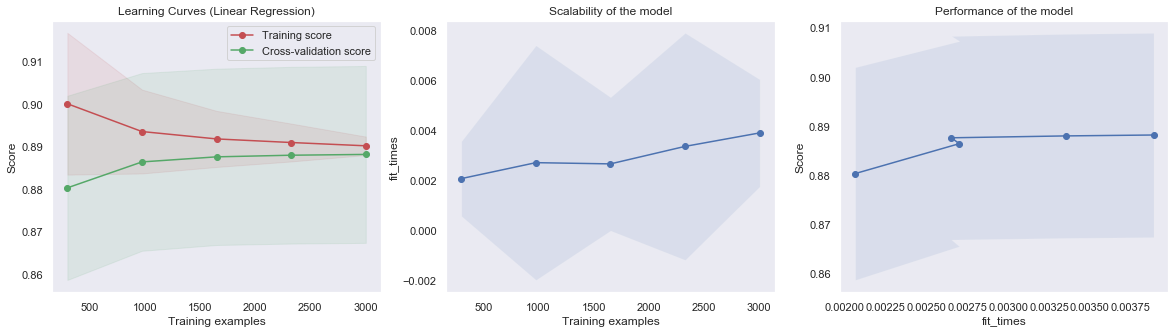

In [457]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 15))


title = "Learning Curves (Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, X_curves, y_train, cv=cv, n_jobs=4)

In [458]:
# results_val=pd.DataFrame()
# for i in range(100,y_train.count()+1,50):
    
#     results_val.loc[i,"RMSE Train"]=validation(X_train_final.iloc[0:i,:],y_train.iloc[0:i], X_train_final.iloc[0:i,:], y_train.iloc[0:i])
#     results_val.loc[i,"RMSE Val"]=validation(X_train_final.iloc[0:i,:],y_train.iloc[0:i], X_val_final, y_val)
#     results_val.loc[i,"Train_Observation"]=i+1
# sns.lineplot(x=results_val["Train_Observation"],y=results_val["RMSE Train"])  
# sns.lineplot(x=results_val["Train_Observation"],y=results_val["RMSE Val"]) 
# plt.legend(labels=["Train", "Validation"])
# plt.ylabel('RMSE',size=12);

In [459]:
round(cross_val_score(estimator, X_curves, y_train, cv=5).mean()*100,2)

88.83

In [460]:
results=predictions(X_train_final,y_train, X_test_final, y_test)

MAE: 5102.48
RMSE: 13355.931224797556
MAPE: 25.89%


In [461]:
index_high_errors=results[results["Difference%"]>results["Difference%"].quantile(0.75)].Car_index
error=results[results["Car_index"].isin(index_high_errors)].loc[:,['Difference%',"Car_index"]]
error.index=error.Car_index
error.index.name = None
error.drop(columns="Car_index",inplace=True)
data_error=data_test.loc[index_high_errors.values,:]
error=error.join(data_error)
error["Price_real"]=np.exp(error["Price"])
error.describe(include="all")


,Difference%,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Price_real
count,209.000000,209,209.000000,209,209.000000,201.000000,209,209,209.000000,209,209.000000
unique,NaN,7,NaN,6,NaN,NaN,4,2,NaN,91,NaN
top,NaN,Mercedes-Benz,NaN,sedan,NaN,NaN,Diesel,True,NaN,Kangoo,NaN
freq,NaN,70,NaN,77,NaN,NaN,104,190,NaN,16,NaN
mean,55.616419,NaN,9.323994,NaN,160.387560,2.707114,NaN,NaN,2005.368421,NaN,25518.326938
std,39.186203,NaN,1.204173,NaN,119.851382,1.255751,NaN,NaN,7.924715,NaN,41375.329374
min,29.867750,NaN,7.090077,NaN,0.000000,1.000000,NaN,NaN,1980.000000,NaN,1200.000000
25%,35.638603,NaN,8.507143,NaN,56.000000,1.800000,NaN,NaN,2000.000000,NaN,4950.000000
50%,43.626846,NaN,9.104980,NaN,157.000000,2.200000,NaN,NaN,2007.000000,NaN,9000.000000
75%,59.278292,NaN,10.064756,NaN,242.000000,3.200000,NaN,NaN,2012.000000,NaN,23500.000000


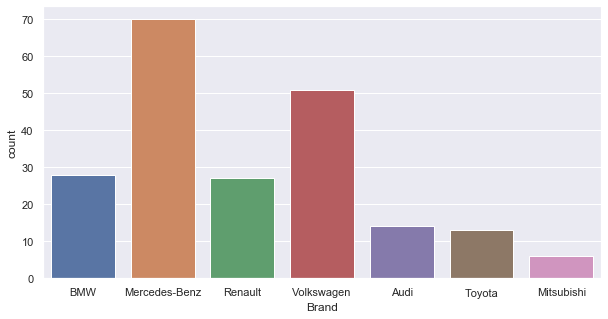

In [462]:
plt.figure(figsize=(10,5))
sns.countplot(error.Brand)

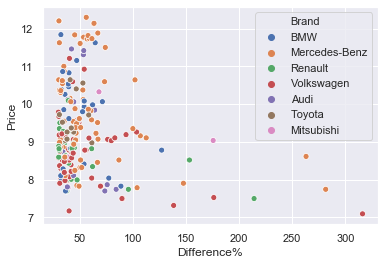

In [463]:
sns.scatterplot(error['Difference%'],error['Price'],hue=error['Brand'])

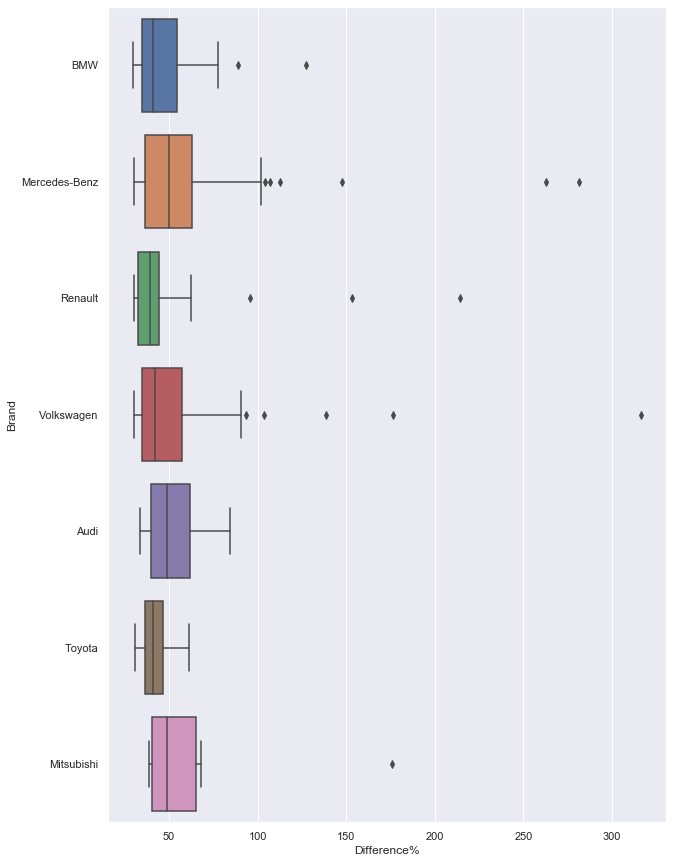

In [464]:
plt.figure(figsize=(10,15))
sns.boxplot(y=error.Brand, x=error['Difference%'], orient='h',whis=1.5);

Mostly errors are lower than 26%, however max difference in % shows that there are may be outliers, which not excluded, or important factors, which not included.

In [465]:
results.describe()

,Prediction,Car_index,Target,Residuals,Difference%
count,835.000000,835.000000,835.000000,835.000000,835.000000
mean,17601.500316,2163.256287,19709.495904,2107.995588,23.848538
std,16996.339509,1269.358970,25967.422353,13196.431765,27.781850
min,1196.620401,1.000000,1200.000000,-42788.896497,0.075391
25%,7530.048475,1035.500000,6999.500000,-1711.807439,8.540794
50%,12343.091628,2172.000000,11500.000000,-108.571894,17.000143
75%,21468.893600,3281.500000,21000.000000,1806.079942,29.843773
max,138831.189584,4341.000000,219900.000000,123745.014415,316.134161


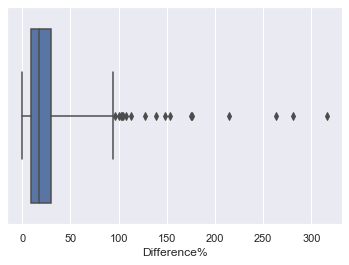

In [466]:
sns.boxplot(results['Difference%'], whis=3)

Let's check few observation with highest errors.

In [467]:
print(results.sort_values(by=['Difference%']).tail(10))

       Prediction  Car_index  Target     Residuals  Difference%
834  14766.205090       4341  6500.0  -8266.205090   127.172386
680   3577.135237       3561  1500.0  -2077.135237   138.475682
144   6687.144674        663  2700.0  -3987.144674   147.672025
99   12667.745537        512  5000.0  -7667.745537   153.354911
226  23154.653305       1127  8400.0 -14754.653305   175.650635
86    5110.281500        470  1850.0  -3260.281500   176.231432
637   5654.215551       3337  1800.0  -3854.215551   214.123086
51   19966.329895        256  5500.0 -14466.329895   263.024180
256   8774.362765       1330  2300.0  -6474.362765   281.494033
93    4993.609932        499  1200.0  -3793.609932   316.134161


In [468]:
data[data.index==3337]

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
3337,Renault,1800.0,van,123.0,1.9,Diesel,True,2004,Kangoo


In [469]:
data[data.Model=='Kangoo'].describe()

,Price,Mileage,EngineV,Year
count,142.000000,142.000000,132.000000,142.000000
mean,6408.971831,151.323944,1.531818,2008.492958
std,2063.957305,61.536537,0.139420,4.198525
min,1300.000000,1.000000,1.000000,1998.000000
25%,4825.000000,119.250000,1.500000,2006.000000
50%,6700.000000,148.000000,1.500000,2009.000000
75%,7500.000000,188.750000,1.500000,2012.000000
max,14999.000000,345.000000,1.900000,2014.000000


In [470]:
data[data.Model=='Kangoo'].sort_values(by=['Price']).head(10)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
1872,Renault,1300.0,van,265.0,1.9,Diesel,False,1999,Kangoo
3337,Renault,1800.0,van,123.0,1.9,Diesel,True,2004,Kangoo
311,Renault,2300.0,van,200.0,1.9,Diesel,True,2002,Kangoo
4182,Renault,2950.0,vagon,280.0,NaN,Diesel,True,2000,Kangoo
2175,Renault,2999.0,van,245.0,1.5,Diesel,True,2003,Kangoo
1997,Renault,3000.0,van,217.0,1.4,Petrol,True,2004,Kangoo
166,Renault,3100.0,van,164.0,1.4,Petrol,True,1999,Kangoo
3635,Renault,3300.0,van,345.0,1.9,Diesel,True,2001,Kangoo
3523,Renault,3300.0,van,256.0,1.5,Diesel,True,2005,Kangoo
2423,Renault,3300.0,van,250.0,1.5,Diesel,True,2005,Kangoo


#### Visual analysis of residuals and forecast

There are some observations that look like outliers. The pattern on the chart doesn't look perfectly random. So maybe better apply different configuration of the model or other method. Residuals are more disperced for lower targets (heteroscedasticity?).

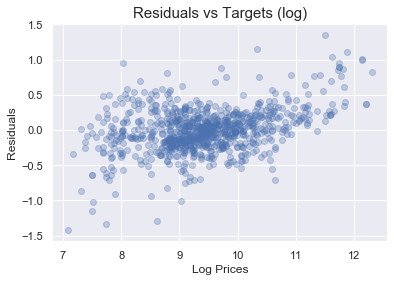

In [471]:
plt.scatter(np.log(results['Target']),np.log(results['Target'])-np.log(results['Prediction']),alpha=0.3)
plt.xlabel('Log Prices',size=12)
plt.ylabel('Residuals',size=12)
plt.title('Residuals vs Targets (log)',size=15);

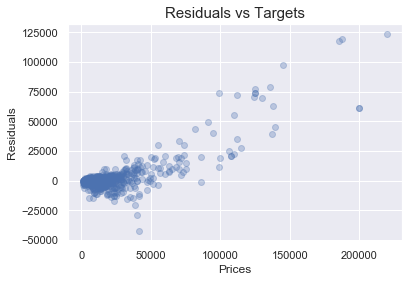

In [472]:
plt.scatter(results['Target'],results['Residuals'],alpha=0.3)
plt.xlabel('Prices',size=12)
plt.ylabel('Residuals',size=12)
plt.title('Residuals vs Targets',size=15);

Histogram of the residuals looks like normally distributed, but with high skewness.

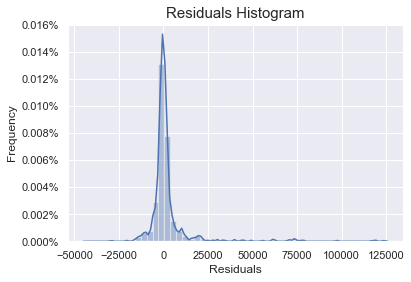

In [473]:
fig, ax = plt.subplots()
sns.distplot(results['Residuals'])
plt.ylabel('Frequency',size=12)
plt.title('Residuals Histogram',size=15)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=3));

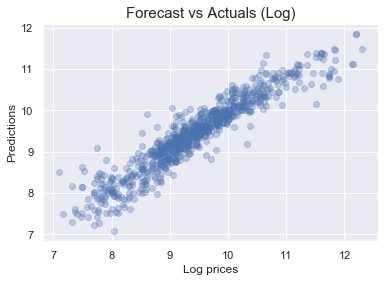

In [474]:
plt.scatter(np.log(results['Target']),np.log(results['Prediction']),alpha=0.3)
plt.xlabel('Log prices',size=12)
plt.ylabel('Predictions',size=12)
plt.title('Forecast vs Actuals (Log)', size=15);


Text(0.5, 1.0, 'Forecast vs Actual')

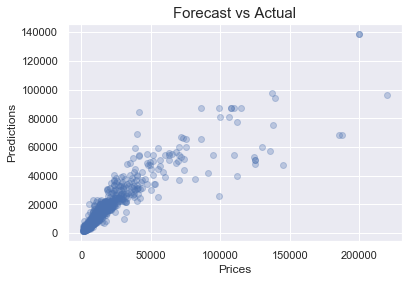

In [475]:
plt.scatter(results['Target'],results['Prediction'],alpha=0.3)
plt.xlabel('Prices',size=12)
plt.ylabel('Predictions',size=12)
plt.title('Forecast vs Actual',size=15)
# plt.xlim(0,70000)
# plt.ylim(0,70000);